In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# библиотека для работы со строками молекул
!pip install rdkit
#plotly
!pip install plotly==5.2.1

# для скачивания файлов
!pip install gdown
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

!pip install catboost
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.multioutput import MultiOutputRegressor

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
from tqdm import tqdm



import warnings
warnings.filterwarnings('ignore')


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 2.7 MB/s eta 0:00:00
  Attempting uninstall: plotly
    Found existing installation: plotly 5.15.0
    Uninstalling plotly-5.15.0:
      Successfully uninstalled plotly-5.15.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 7.6 MB/s eta 0:00:00


In [ ]:
#perturbations.pickle
!gdown --id  1fG_oErAcUKmHIPF6AZBMX9VLU8LtVj1T
#id_map.csv
!gdown --id  17M1Doy4uXT_OE2Hc9eo1JaUYRcW-6u25
#atoms_data.csv
!gdown --id  1-Y9GUqBekxAV4cYBj5mmDy2OdNdpChIF

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1fG_oErAcUKmHIPF6AZBMX9VLU8LtVj1T
To: /content/perturbations.pickle
100% 89.6M/89.6M [00:01<00:00, 56.7MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=17M1Doy4uXT_OE2Hc9eo1JaUYRcW-6u25
To: /content/id_map.csv
100% 6.98k/6.98k [00:00<00:00, 13.5MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: http

In [ ]:
import pandas as pd
de_train = pd.read_pickle("perturbations.pickle") # train dataset

### Описание данных
de_train.parquet — агрегированные данные дифференциального выражения в формате плотного массива.

- гены A1BG, A1BG-AS1, …, ZZEF1(всего 18 211) - Значение дифференциальной экспрессии для каждого гена.

- cell_type- Аннотированный тип каждой клетки на основе экспрессии РНК.

- sm_name- Основное имя (родительского) соединения (в стандартизированном представлении), выбранное LINCS.

- sm_lincs_id- Глобальный идентификатор LINCS ID (родительского) соединения (в стандартизированном представлении).

- SMILES- Упрощенная система молекулярного ввода (SMILES) представляет соединения, использованные в эксперименте. Это одномерное представление молекулярной структуры.

- control— Логическое значение, указывающее, использовался ли этот экземпляр в качестве элемента управления.


In [ ]:
de_train.head(10)

,cell_type,sm_name,sm_lincs_id,SMILES,control,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,NK cells,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.104720,-0.077524,-1.625596,-0.144545,0.143555,...,-0.227781,-0.010752,-0.023881,0.674536,-0.453068,0.005164,-0.094959,0.034127,0.221377,0.368755
1,T cells CD4+,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.915953,-0.884380,0.371834,-0.081677,-0.498266,...,-0.494985,-0.303419,0.304955,-0.333905,-0.315516,-0.369626,-0.095079,0.704780,1.096702,-0.869887
2,T cells CD8+,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,-0.387721,-0.305378,0.567777,0.303895,-0.022653,...,-0.119422,-0.033608,-0.153123,0.183597,-0.555678,-1.494789,-0.213550,0.415768,0.078439,-0.259365
3,T regulatory cells,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.232893,0.129029,0.336897,0.486946,0.767661,...,0.451679,0.704643,0.015468,-0.103868,0.865027,0.189114,0.224700,-0.048233,0.216139,-0.085024
4,NK cells,Mometasone Furoate,LSM-3349,C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C...,False,4.290652,-0.063864,-0.017443,-0.541154,0.570982,...,0.758474,0.510762,0.607401,-0.123059,0.214366,0.487838,-0.819775,0.112365,-0.122193,0.676629
5,T cells CD4+,Mometasone Furoate,LSM-3349,C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C...,False,0.618061,0.180148,0.590015,0.035658,0.034297,...,-1.002997,0.177514,0.591768,-0.412400,-0.011633,-0.044739,0.213627,0.186406,-1.459477,1.164084
6,T cells CD8+,Mometasone Furoate,LSM-3349,C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C...,False,-0.148131,0.091336,-0.097212,1.225601,0.045787,...,-0.228645,0.091248,-0.581765,0.405682,-0.034414,0.296333,0.170313,0.332022,-0.532363,0.134475
7,T regulatory cells,Mometasone Furoate,LSM-3349,C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C...,False,0.561473,0.149415,3.224920,3.517419,1.361175,...,-0.156127,0.766118,0.702836,0.949482,0.757482,1.163063,1.532419,-0.399292,-2.412165,0.478977
8,B cells,Idelalisib,LSM-1205,CC[C@H](Nc1ncnc2[nH]cnc12)c1nc2cccc(F)c2c(=O)n...,False,0.394173,-0.153824,0.178232,0.566241,0.391377,...,-1.052302,-1.176587,-1.220291,-0.278944,-0.095066,1.101790,0.061803,1.406335,-0.264996,-0.119743
9,Myeloid cells,Idelalisib,LSM-1205,CC[C@H](Nc1ncnc2[nH]cnc12)c1nc2cccc(F)c2c(=O)n...,False,0.025146,0.316388,1.366885,1.301593,2.317619,...,-0.902546,-1.445523,0.794772,0.428973,0.605834,0.271988,0.492231,0.354721,1.471559,-0.259483


Посмотрим на описание признаков; остальные колонки нужно предсказать - они предстают из себя экспрессию в каждом из генов

In [ ]:
de_train[de_train["control"]]

,cell_type,sm_name,sm_lincs_id,SMILES,control,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
104,B cells,Dabrafenib,LSM-6303,CC(C)(C)c1nc(-c2cccc(NS(=O)(=O)c3c(F)cccc3F)c2...,True,0.942197,0.539713,-0.417087,0.391397,2.049071,...,-0.094318,-0.043478,-0.269027,0.484859,0.905045,0.277953,1.126481,0.432023,-2.508760,-0.354758
105,Myeloid cells,Dabrafenib,LSM-6303,CC(C)(C)c1nc(-c2cccc(NS(=O)(=O)c3c(F)cccc3F)c2...,True,0.254567,0.244074,-28.552191,-0.377238,-0.731186,...,1.771915,-0.085585,0.010659,-1.890484,1.062484,-0.136040,-0.224016,-1.890099,-3.105304,-1.155821
106,NK cells,Dabrafenib,LSM-6303,CC(C)(C)c1nc(-c2cccc(NS(=O)(=O)c3c(F)cccc3F)c2...,True,-0.161665,0.269009,-1.770091,-0.198444,0.954753,...,0.131425,-1.112697,-0.589313,-0.660929,0.016530,0.319136,0.299521,-0.383452,0.267828,-1.100267
107,T cells CD4+,Dabrafenib,LSM-6303,CC(C)(C)c1nc(-c2cccc(NS(=O)(=O)c3c(F)cccc3F)c2...,True,0.000443,0.750020,-0.151077,-2.733638,-1.073863,...,-1.032259,-0.571065,0.346539,-0.338557,0.549544,-0.607941,-0.130692,-0.059547,-0.169427,-1.992270
108,T cells CD8+,Dabrafenib,LSM-6303,CC(C)(C)c1nc(-c2cccc(NS(=O)(=O)c3c(F)cccc3F)c2...,True,0.103281,-0.281974,-0.187118,0.535779,1.201660,...,-0.288675,-0.156537,-0.555925,-0.564582,0.735246,-0.641172,0.272963,-0.482503,-0.498744,-0.097232
109,T regulatory cells,Dabrafenib,LSM-6303,CC(C)(C)c1nc(-c2cccc(NS(=O)(=O)c3c(F)cccc3F)c2...,True,0.679796,0.457679,2.576746,2.151973,2.649578,...,-1.295633,1.393517,0.098008,0.523280,0.871999,2.195867,1.880501,0.489364,-0.388891,-0.617592
275,B cells,Belinostat,LSM-43181,O=C(/C=C/c1cccc(S(=O)(=O)Nc2ccccc2)c1)NO,True,2.225073,0.564347,-0.437639,-0.415907,0.307772,...,10.803264,3.292811,-0.051246,0.247855,-1.651776,-1.788311,-0.418805,3.396236,-0.567121,0.501423
276,Myeloid cells,Belinostat,LSM-43181,O=C(/C=C/c1cccc(S(=O)(=O)Nc2ccccc2)c1)NO,True,3.519499,6.284255,-24.687990,0.004540,15.109208,...,0.635599,0.210030,-21.273505,1.190610,-0.486464,-1.040062,-8.310726,0.612581,7.826692,-0.917186
277,NK cells,Belinostat,LSM-43181,O=C(/C=C/c1cccc(S(=O)(=O)Nc2ccccc2)c1)NO,True,1.181036,3.652341,-7.026508,-17.801989,-0.656651,...,4.361655,0.558856,-0.809408,0.265743,-0.056795,-0.019083,-0.140576,3.909364,-1.252862,-1.467913
278,T cells CD4+,Belinostat,LSM-43181,O=C(/C=C/c1cccc(S(=O)(=O)Nc2ccccc2)c1)NO,True,0.858771,3.672879,-3.525978,-13.130322,-2.264816,...,4.859433,4.253850,0.628184,0.332405,-6.780020,-2.497143,-0.868885,3.692675,0.128906,-0.583605


In [ ]:
de_train[["cell_type", "sm_name", "sm_lincs_id", "SMILES", "control"]].describe()

,cell_type,sm_name,sm_lincs_id,SMILES,control
count,614,614,614,614,614
unique,6,146,146,146,2
top,NK cells,R428,LSM-45574,Nc1nc(Nc2ccc3c(c2)CC[C@@H](N2CCCC2)CC3)nn1-c1c...,False
freq,146,6,6,6,602


Информация о клетках:

,Общее количество,"Доля, %"
cell_type,,
NK cells,146,0.237785
T cells CD4+,146,0.237785
T regulatory cells,146,0.237785
T cells CD8+,142,0.231270
B cells,17,0.027687
Myeloid cells,17,0.027687


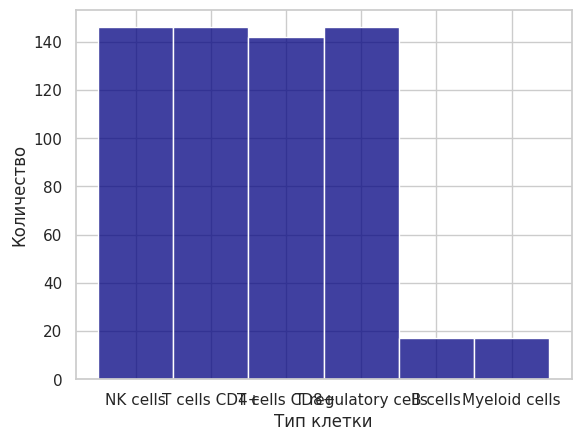

In [ ]:

sns.set_theme(style="whitegrid", palette="pastel")
sns.histplot(data = de_train,  x = 'cell_type', color = 'navy', bins = 10)
plt.xlabel("Тип клетки")
plt.ylabel("Количество")
pd.DataFrame(data= {'Общее количество': de_train['cell_type'].value_counts(),
                    'Доля, %': de_train['cell_type'].value_counts(normalize=True)})

Датасет, предсказание по которому мы делаем сабмит:

In [ ]:
id_map = pd.read_csv("id_map.csv").drop('id', axis = 1) # test dataset

In [ ]:
id_map.head(10)

,cell_type,sm_name
0,B cells,5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin-...
1,B cells,ABT-199 (GDC-0199)
2,B cells,ABT737
3,B cells,AMD-070 (hydrochloride)
4,B cells,AT 7867
5,B cells,AT13387
6,B cells,AVL-292
7,B cells,AZ628
8,B cells,AZD-8330
9,B cells,AZD3514


В тестовом датасете представлены только 2 вида клеток: Myeloid cells и B cells

In [ ]:
id_map.describe()

,cell_type,sm_name
count,255,255
unique,2,129
top,B cells,5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin-...
freq,128,2


Экспрессия для 18211 гена; для дальнейшей работы запомним названия всех этих генов

In [ ]:
gene_names = de_train.iloc[:,5:].columns
de_train[gene_names]

,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,AACS,AAGAB,AAK1,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,0.104720,-0.077524,-1.625596,-0.144545,0.143555,0.073229,-0.016823,0.101717,-0.005153,1.043629,...,-0.227781,-0.010752,-0.023881,0.674536,-0.453068,0.005164,-0.094959,0.034127,0.221377,0.368755
1,0.915953,-0.884380,0.371834,-0.081677,-0.498266,0.203559,0.604656,0.498592,-0.317184,0.375550,...,-0.494985,-0.303419,0.304955,-0.333905,-0.315516,-0.369626,-0.095079,0.704780,1.096702,-0.869887
2,-0.387721,-0.305378,0.567777,0.303895,-0.022653,-0.480681,0.467144,-0.293205,-0.005098,0.214918,...,-0.119422,-0.033608,-0.153123,0.183597,-0.555678,-1.494789,-0.213550,0.415768,0.078439,-0.259365
3,0.232893,0.129029,0.336897,0.486946,0.767661,0.718590,-0.162145,0.157206,-3.654218,-0.212402,...,0.451679,0.704643,0.015468,-0.103868,0.865027,0.189114,0.224700,-0.048233,0.216139,-0.085024
4,4.290652,-0.063864,-0.017443,-0.541154,0.570982,2.022829,0.600011,1.231275,0.236739,0.338703,...,0.758474,0.510762,0.607401,-0.123059,0.214366,0.487838,-0.819775,0.112365,-0.122193,0.676629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,-0.014372,-0.122464,-0.456366,-0.147894,-0.545382,-0.544709,0.282458,-0.431359,-0.364961,0.043123,...,-0.549987,-2.200925,0.359806,1.073983,0.356939,-0.029603,-0.528817,0.105138,0.491015,-0.979951
610,-0.455549,0.188181,0.595734,-0.100299,0.786192,0.090954,0.169523,0.428297,0.106553,0.435088,...,-1.236905,0.003854,-0.197569,-0.175307,0.101391,1.028394,0.034144,-0.231642,1.023994,-0.064760
611,0.338168,-0.109079,0.270182,-0.436586,-0.069476,-0.061539,0.002818,-0.027167,-0.383696,0.226289,...,0.077579,-1.101637,0.457201,0.535184,-0.198404,-0.005004,0.552810,-0.209077,0.389751,-0.337082
612,0.101138,-0.409724,-0.606292,-0.071300,-0.001789,-0.706087,-0.620919,-1.485381,0.059303,-0.032584,...,0.005951,-0.893093,-1.003029,-0.080367,-0.076604,0.024849,0.012862,-0.029684,0.005506,-1.733112


Посмотрим на распределение средних значений экспрессии построчно:

Информация о средних значениях: 
 count    614.000000
mean       0.323306
std        1.222391
min       -1.454919
25%       -0.023740
50%        0.060241
75%        0.214869
max       15.778056
Name: mean_expression, dtype: float64


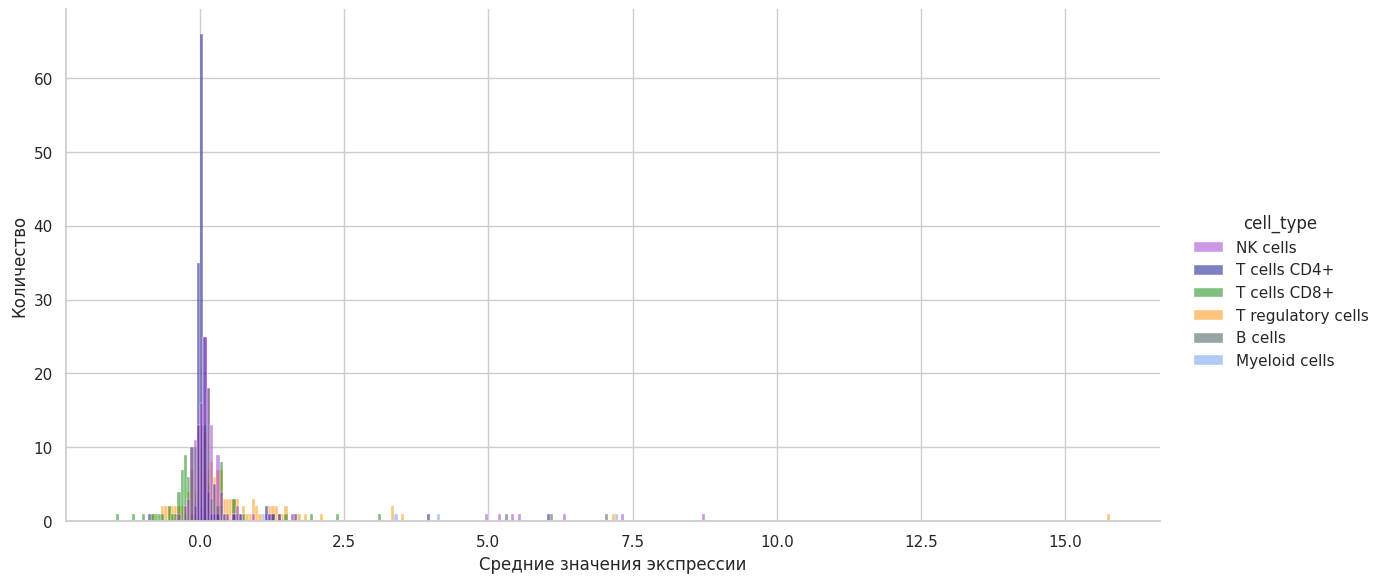

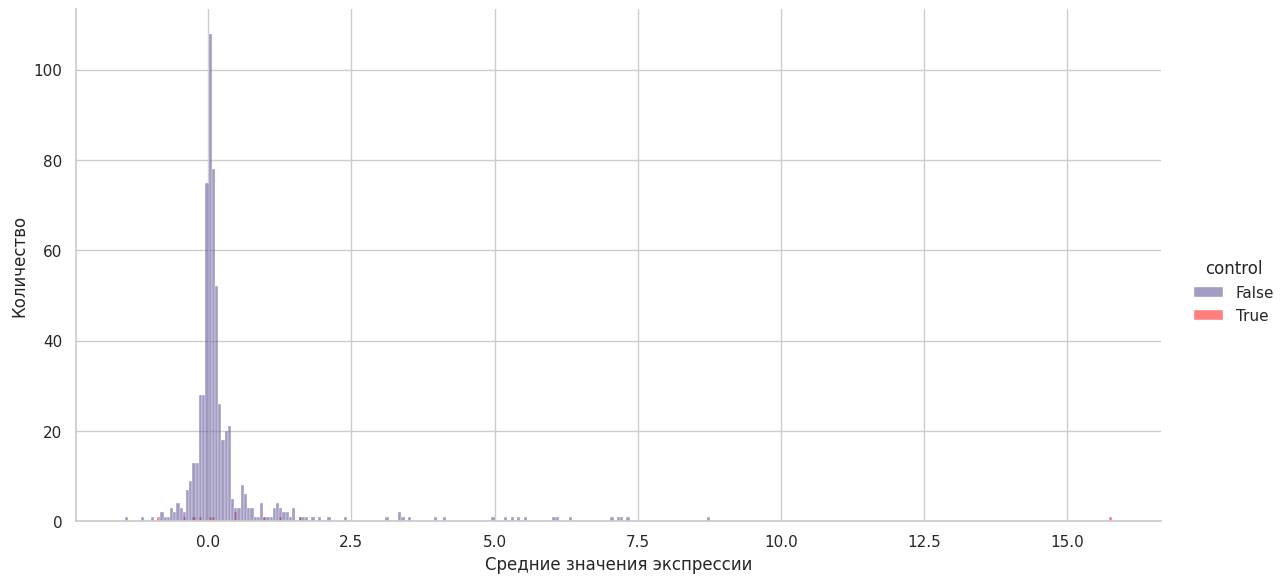

In [ ]:
palette = ["#9932CC", "#00008B", "#008000", "#FF8C00", "#2F4F4F", "#6495ED"]

de_train['mean_expression'] = de_train[gene_names].mean(axis = 1)
de_train['mean_expression'] = de_train['mean_expression']
sns.displot(data=de_train,x ='mean_expression', hue='cell_type', height=6, aspect=2, palette = palette)
plt.xlabel("Средние значения экспрессии")
plt.ylabel("Количество")
sns.displot(data=de_train,x ='mean_expression', hue='control', height=6, aspect=2, palette = ["#483D8B", "red"])
plt.xlabel("Средние значения экспрессии")
plt.ylabel("Количество")
None
print("Информация о средних значениях: \n", de_train['mean_expression'].describe())

Тест Шапиро-Уилка+ qqplot


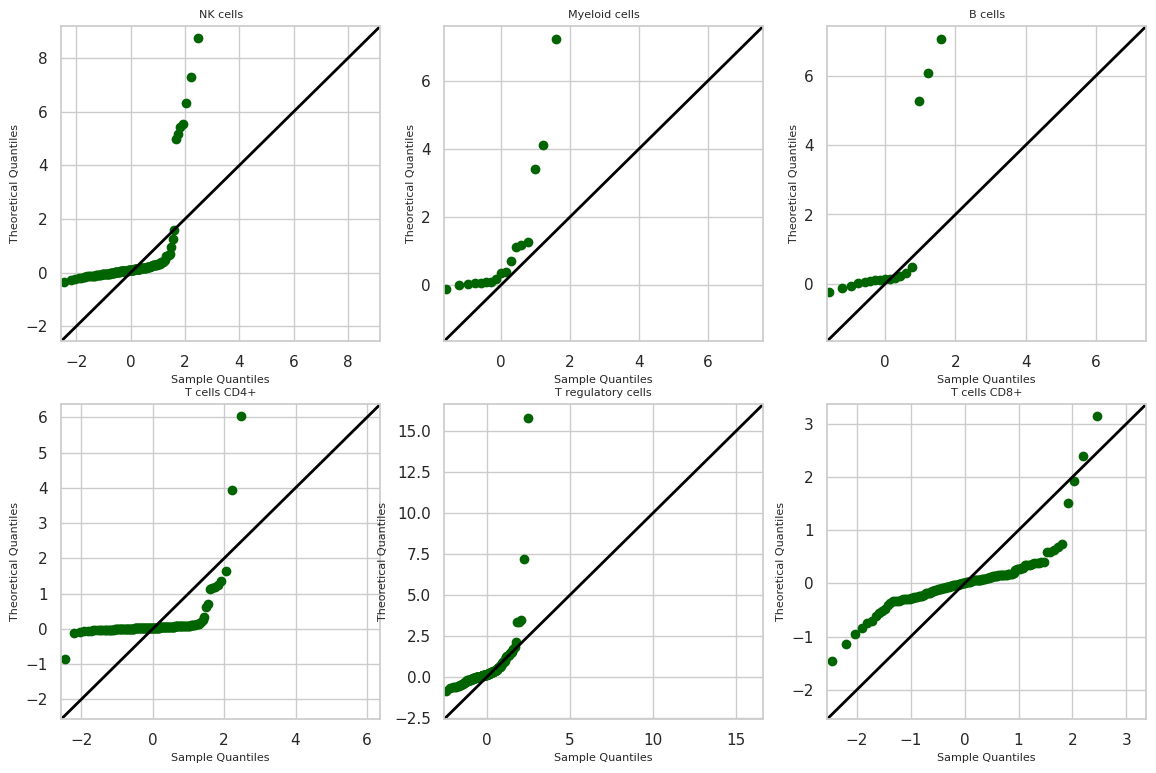

In [ ]:
from scipy.stats import shapiro

import statsmodels.api as sm

fig, ax = plt.subplots(2, 3, figsize=(14, 9))
ax = np.ravel(ax)
i= 0
for cell in set(de_train["cell_type"]):
    sm.qqplot(de_train["mean_expression"][de_train["cell_type"]==cell], line='45', ax = ax[i],
              markerfacecolor='#006400',
              markeredgecolor='#006400')
    ax[i].set_title(cell, fontsize = 8)
    ax[i].get_lines()[1].set_color("black")
    ax[i].get_lines()[1].set_linewidth("2")
    ax[i].set_xlabel('Sample Quantiles', fontsize = 8)
    ax[i].set_ylabel('Theoretical Quantiles', fontsize = 8)
    i+=1

Violin plots and Boxplots:

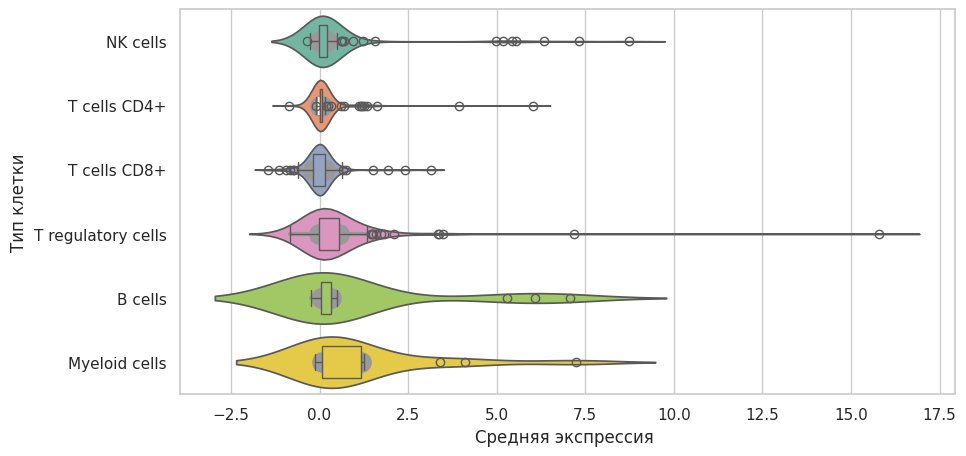

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.set_style("whitegrid")
ax = sns.violinplot(data=de_train, y = 'cell_type', x ='mean_expression', palette="Set2",
               inner_kws=dict(box_width=15, whis_width=3, color=".6"))
sns.boxplot(data=de_train, y = 'cell_type', x ='mean_expression', ax=ax, palette="Set2", width=.5,
            boxprops={'zorder':5})
plt.ylabel("Тип клетки")
plt.xlabel("Средняя экспрессия ")
None


In [ ]:
de_train["mean_expression"]

0      0.114498
1      0.020473
2     -0.235096
3      0.323229
4      0.640715
         ...   
609   -0.477640
610    0.063603
611   -0.021596
612   -0.301588
613   -0.517785
Name: mean_expression, Length: 614, dtype: float64

Визуализируем точки на плоскости, уменьшив размерность данных - применим PCA

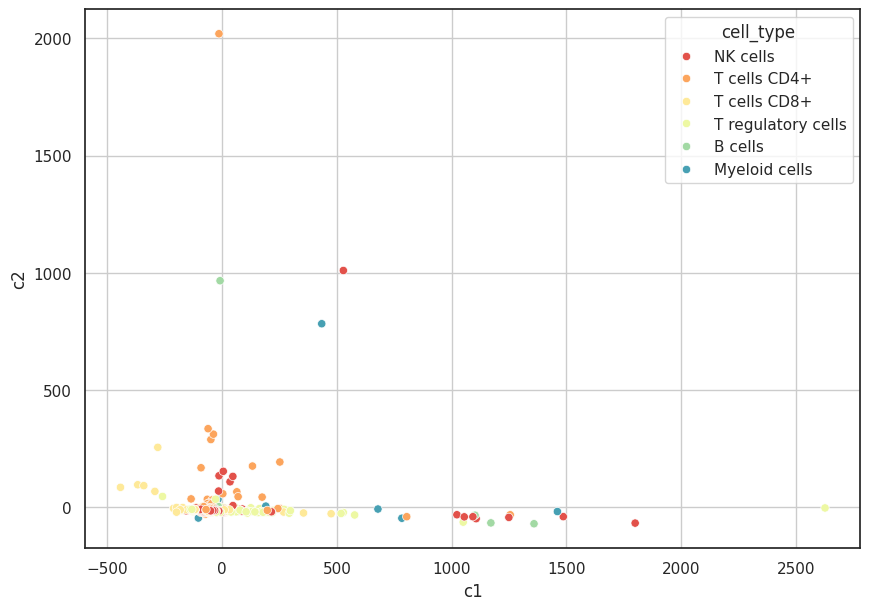

In [ ]:
fig = plt.figure(figsize=(10,7))
sns.set_theme(style="white")

genes_data = de_train[gene_names]

pca = PCA(n_components=2)
pca_genes = pd.DataFrame(pca.fit_transform(genes_data), columns = ["c1", "c2"])


sns.scatterplot(data = pca_genes, x= "c1", y = "c2", hue = de_train['cell_type'], palette = "Spectral")
plt.grid()

None

LDA

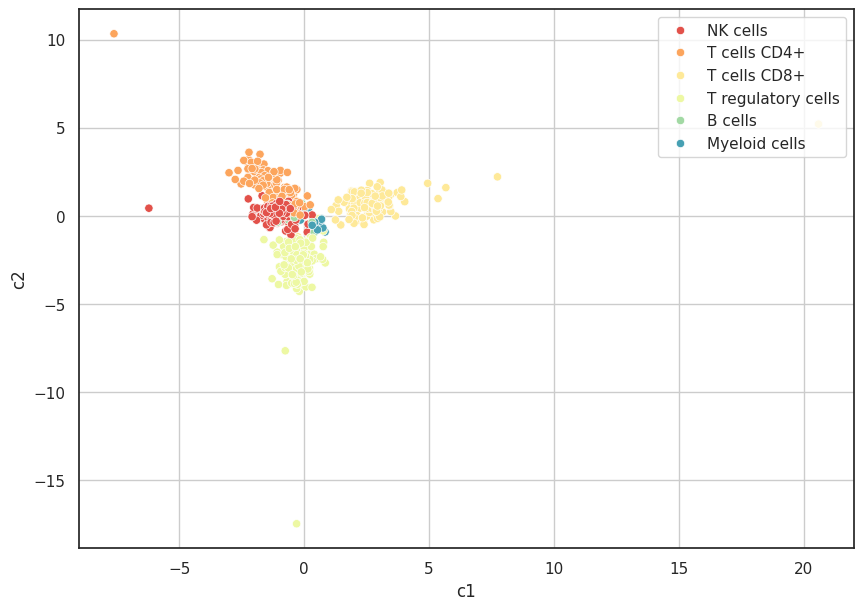

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

fig = plt.figure(figsize=(10,7))
sns.set_theme(style="white")

lda = LinearDiscriminantAnalysis(n_components=2)



lda_genes = pd.DataFrame(lda.fit_transform(genes_data, de_train['cell_type']), columns = ["c1", "c2"])


sns.scatterplot(data = lda_genes, x= "c1", y = "c2", hue = de_train['cell_type'], palette = "Spectral")
plt.grid()
plt.legend(loc = "upper right")

None

PCA не является методом визуализации данных; лучше для этих задач применить t-SNE

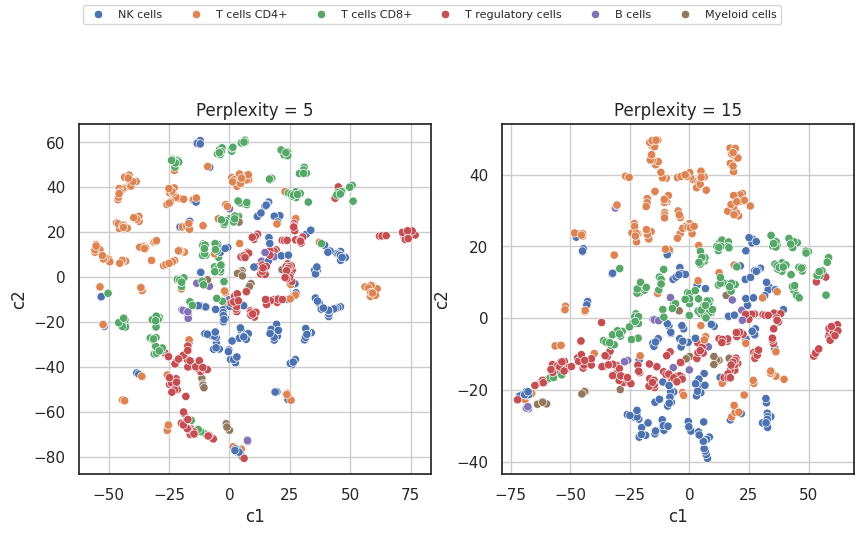

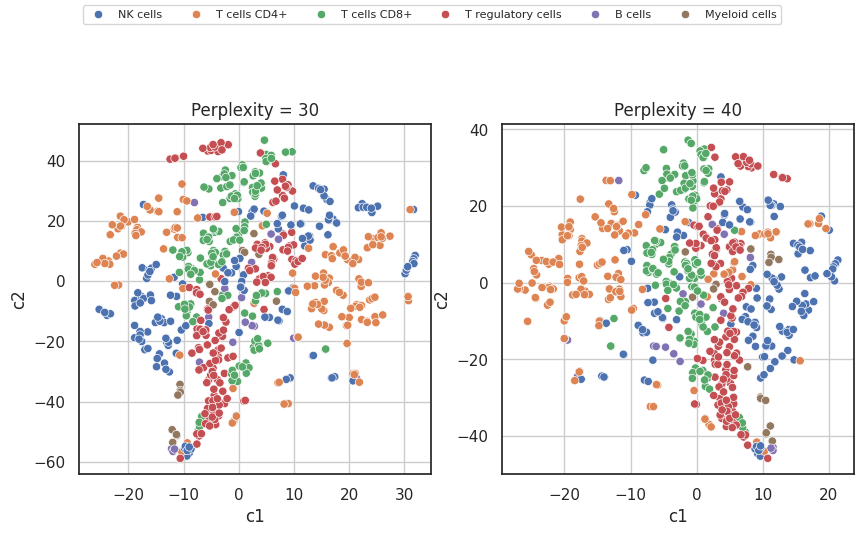

In [ ]:
fig = plt.figure(figsize=(10,10))
sns.set_theme(style="white")

t_sne_genes_5 = pd.DataFrame(TSNE(n_components=2, learning_rate='auto',
init='random', n_jobs = -1, perplexity = 5).fit_transform(de_train[gene_names]), columns = ["c1", "c2"])

t_sne_genes_15 = pd.DataFrame(TSNE(n_components=2, learning_rate='auto',
init='random', n_jobs = -1, perplexity = 10).fit_transform(de_train[gene_names]), columns = ["c1", "c2"])

t_sne_genes_30 = pd.DataFrame(TSNE(n_components=2, learning_rate='auto',
init='random', n_jobs = -1, perplexity = 20).fit_transform(de_train[gene_names]), columns = ["c1", "c2"])

t_sne_genes_40 = pd.DataFrame(TSNE(n_components=2, learning_rate='auto',
init='random', n_jobs = -1, perplexity = 30).fit_transform(de_train[gene_names]), columns = ["c1", "c2"])

# len_genes = len(t_sne_genes)
# t_sne_genes["perplexity"] = np.array([5]*len_genes)

# for perplexity in tqdm(range(7, 51, 2)):
#     t_sne_genes_in_loop = pd.DataFrame(TSNE(n_components=2, learning_rate='auto',
#     init='random', n_jobs = -1, perplexity = 5).fit_transform(de_train[gene_names]), columns = ["c1", "c2"])
#     t_sne_genes_in_loop["perplexity"] = np.array([perplexity]*len_genes)
#     t_sne_genes = pd.concat([t_sne_genes, t_sne_genes_in_loop], ignore_index=True)



fig.add_subplot(221)
plt.title("Perplexity = 5")
sns.scatterplot(data = t_sne_genes_5, x= "c1", y = "c2", hue = de_train['cell_type'])
plt.grid()
plt.legend('',frameon=False)
fig.legend(fontsize="8", ncol=6, loc=9)


fig.add_subplot(222)
plt.title("Perplexity = 15")
sns.scatterplot(data = t_sne_genes_15, x= "c1", y = "c2", hue = de_train['cell_type'])
plt.grid()
plt.legend('',frameon=False)

fig = plt.figure(figsize=(10,10))
sns.set_theme(style="white")

fig.add_subplot(221)
plt.title("Perplexity = 30")
sns.scatterplot(data = t_sne_genes_30, x= "c1", y = "c2", hue = de_train['cell_type'])
plt.grid()
plt.legend('',frameon=False)
fig.legend(fontsize="8", ncol=6, loc=9)

fig.add_subplot(222)
plt.title("Perplexity = 40")
sns.scatterplot(data = t_sne_genes_40, x= "c1", y = "c2", hue = de_train['cell_type'])
plt.grid()
plt.legend('',frameon=False)



None
# из предыдущих графиков можем заметить, что случаи, когда экземпляр является элементом управления (control = True)
# являются, скорее, выбросами - соотвественно, колонку control использовать как признак не имеет большого смысла
# также стоит провести исследование: зависимость расположения точек от перплексии - целевое количество ближайших соседей к точке

Сравним t-SNE с UMAP - он тоже призван сохранять локальные расстояния между точками

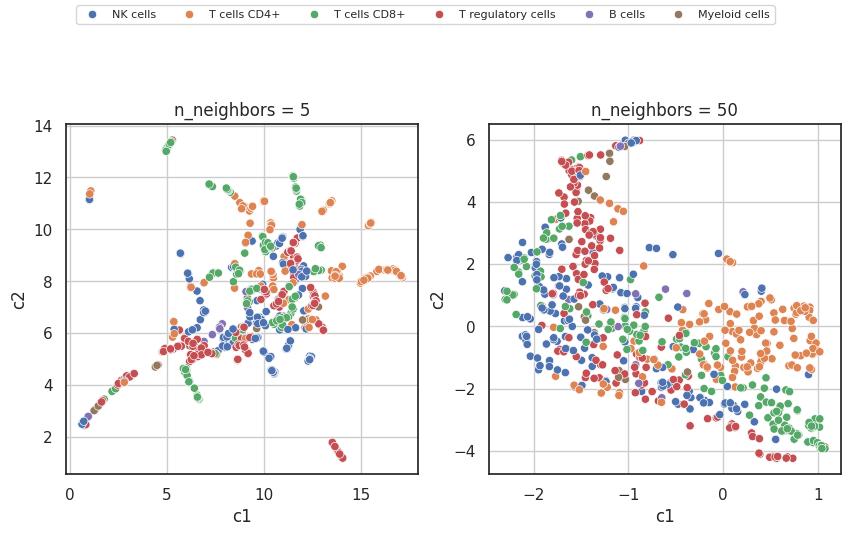

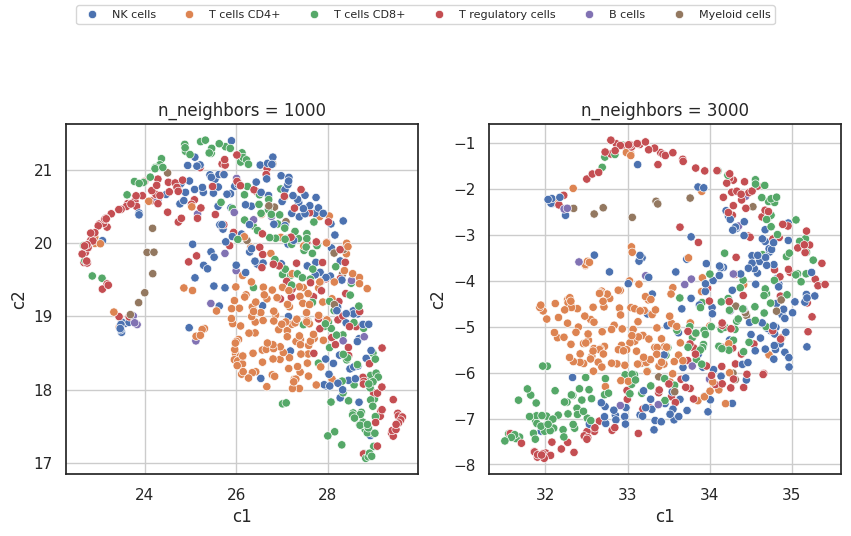

In [ ]:
!pip install umap-learn
import umap

fig = plt.figure(figsize=(10,10))
sns.set_theme(style="white")
umap_genes_5 = pd.DataFrame(umap.UMAP(n_neighbors = 5).fit_transform(de_train[gene_names]),
                          columns = ["c1", "c2"])

umap_genes_15 = pd.DataFrame(umap.UMAP(n_neighbors = 50).fit_transform(de_train[gene_names]),
                          columns = ["c1", "c2"])

umap_genes_30 = pd.DataFrame(umap.UMAP(n_neighbors = 1000).fit_transform(de_train[gene_names]),
                          columns = ["c1", "c2"])

umap_genes_40 = pd.DataFrame(umap.UMAP(n_neighbors = 3000).fit_transform(de_train[gene_names]),
                          columns = ["c1", "c2"])

fig.add_subplot(221)
plt.title("n_neighbors = 5")
sns.scatterplot(data = umap_genes_5, x= "c1", y = "c2", hue = de_train['cell_type'])
plt.grid()
plt.legend('',frameon=False)
fig.legend(fontsize="8", ncol=6, loc=9)


fig.add_subplot(222)
plt.title("n_neighbors = 50")
sns.scatterplot(data = umap_genes_15, x= "c1", y = "c2", hue = de_train['cell_type'])
plt.grid()
plt.legend('',frameon=False)

fig = plt.figure(figsize=(10,10))
sns.set_theme(style="white")

fig.add_subplot(221)
plt.title("n_neighbors = 1000")
sns.scatterplot(data = umap_genes_30, x= "c1", y = "c2", hue = de_train['cell_type'])
plt.grid()
plt.legend('',frameon=False)
fig.legend(fontsize="8", ncol=6, loc=9)

fig.add_subplot(222)
plt.title("n_neighbors = 3000")
sns.scatterplot(data = umap_genes_40, x= "c1", y = "c2", hue = de_train['cell_type'])
plt.grid()
plt.legend('',frameon=False)
None

Посмотрим информацию о молекулах: посмотрим их структуру, выясним, из каких атомов она состоит и сформируем новые признаки на основе новых данных

Ниже представлена функция, возвращающая словарь- информацию о количестве атомов в каждой из молекул

In [ ]:
import re
def element_count(data: pd.DataFrame, observation_number: int)->dict:
    """
    data: DataFrame, в котором есть колонка с молекулами в строковом виде
    observation_number: номер наблюдения
    """
    smiles = data['SMILES'].iloc[observation_number]
    pattern = "Si|Ti|Al|Zn|Pd|Pt|Br?|Cl?|N|O|S|P|F|I|B|b|c|n|o|s|p"
    regex = re.compile(pattern)
    elements = [token for token in regex.findall(smiles)]
    ele_length = len(elements)
    lowercase_pattern = "b|c|n|o|s|p"
    regex_low = re.compile(lowercase_pattern)
    for i in range(ele_length):
        if regex_low.findall(elements[i]):
            elements[i] = elements[i].upper()
    element_count = [elements.count(ele) for ele in elements]
    formula = dict(zip(elements, element_count))
    return formula

Создадим датафрейм, где для каждой из молекул приведем количество того или иного атома в ней

In [ ]:
unique_smiles = de_train.SMILES.unique() # список из уникальных молекул
len_unique_smiles = len(unique_smiles)


# создаем датафрейм, в котором для каждой молекулы приведем информаицю по атомам в ней
atoms_data = pd.DataFrame({"SMILES": unique_smiles})

for i in range(len_unique_smiles):
    dict_elem = element_count(de_train, i)
    for atom in dict_elem:
        if atom not in atoms_data.columns:
            atoms_data[atom] = np.zeros(len_unique_smiles)
        atoms_data[atom].iloc[i] = dict_elem[atom]

atoms_data.head(10)

,SMILES,Cl,C,N,O,F,Br,S,I,B
0,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,1.0,22.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
1,C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C...,1.0,22.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
2,CC[C@H](Nc1ncnc2[nH]cnc12)c1nc2cccc(F)c2c(=O)n...,1.0,22.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
3,COc1cc2c(Nc3ccc(Br)cc3F)ncnc2cc1OCC1CCN(C)CC1,1.0,22.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
4,COc1cc(Nc2c(C#N)cnc3cc(OCCCN4CCN(C)CC4)c(OC)cc...,2.0,27.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0
5,Cc1cc(Nc2ncc(Cl)c(Nc3ccccc3S(=O)(=O)C(C)C)n2)c...,2.0,27.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0
6,Nc1ccn([C@@H]2CS[C@H](CO)O2)c(=O)n1,2.0,27.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0
7,C[C@@H](Oc1cc(-c2cnn(C3CCNCC3)c2)cnc1N)c1c(Cl)...,2.0,27.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0
8,COc1cc2nccc(Oc3ccc(NC(=O)C4(C(=O)Nc5ccc(F)cc5)...,0.0,22.0,7.0,1.0,1.0,0.0,0.0,0.0,0.0
9,CC(C)C(=O)Nc1ccc([N+](=O)[O-])c(C(F)(F)F)c1,0.0,22.0,7.0,1.0,1.0,0.0,0.0,0.0,0.0


Сохраним результат

In [ ]:
atoms_data.to_csv("atoms_data.csv")

RDKit позволяет визуализировать молекулы:

'C=CC(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2cc1OCCCN1CCOCC1'

'Canertinib'

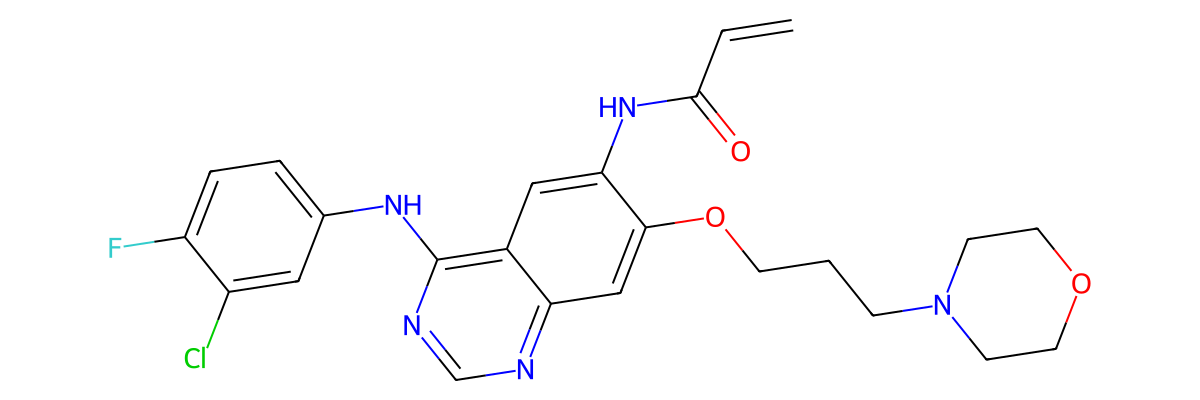

In [ ]:
# визуализируем одну из молекул
num_mol = np.random.choice(range(0, len_unique_smiles-1))
mol = Chem.MolFromSmiles(de_train.SMILES[num_mol])
display(de_train.SMILES[num_mol])
display(de_train.sm_name[num_mol])
Draw.MolToImage(mol, size=(1200, 400), fitImage=True)

RDKit также позваоляет получить информацию о количестве связей и атомов в молекуле

In [ ]:
from rdkit.Chem.Crippen import MolLogP

de_train["num_atoms"] = de_train.SMILES.apply(lambda x: Chem.MolFromSmiles(x).GetNumAtoms()) # количество атомов в структуре
de_train["num_bonds"] = de_train.SMILES.apply(lambda x: Chem.MolFromSmiles(x).GetNumBonds()) # количество связей в молекуле
de_train["MolLogP"] = de_train.SMILES.apply(lambda x: MolLogP(Chem.MolFromSmiles(x)))  #  log of Molar Refractivity

 Посмотрим на наш dataframe:

In [ ]:
de_train.head(10)

,cell_type,sm_name,sm_lincs_id,SMILES,control,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,...,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1,mean_expression,num_atoms,num_bonds,MolLogP
0,NK cells,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.104720,-0.077524,-1.625596,-0.144545,0.143555,...,-0.453068,0.005164,-0.094959,0.034127,0.221377,0.368755,0.114498,25,28,5.3767
1,T cells CD4+,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.915953,-0.884380,0.371834,-0.081677,-0.498266,...,-0.315516,-0.369626,-0.095079,0.704780,1.096702,-0.869887,0.020473,25,28,5.3767
2,T cells CD8+,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,-0.387721,-0.305378,0.567777,0.303895,-0.022653,...,-0.555678,-1.494789,-0.213550,0.415768,0.078439,-0.259365,-0.235096,25,28,5.3767
3,T regulatory cells,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.232893,0.129029,0.336897,0.486946,0.767661,...,0.865027,0.189114,0.224700,-0.048233,0.216139,-0.085024,0.323229,25,28,5.3767
4,NK cells,Mometasone Furoate,LSM-3349,C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C...,False,4.290652,-0.063864,-0.017443,-0.541154,0.570982,...,0.214366,0.487838,-0.819775,0.112365,-0.122193,0.676629,0.640715,35,39,4.8692
5,T cells CD4+,Mometasone Furoate,LSM-3349,C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C...,False,0.618061,0.180148,0.590015,0.035658,0.034297,...,-0.011633,-0.044739,0.213627,0.186406,-1.459477,1.164084,0.144236,35,39,4.8692
6,T cells CD8+,Mometasone Furoate,LSM-3349,C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C...,False,-0.148131,0.091336,-0.097212,1.225601,0.045787,...,-0.034414,0.296333,0.170313,0.332022,-0.532363,0.134475,0.121848,35,39,4.8692
7,T regulatory cells,Mometasone Furoate,LSM-3349,C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C...,False,0.561473,0.149415,3.224920,3.517419,1.361175,...,0.757482,1.163063,1.532419,-0.399292,-2.412165,0.478977,0.600752,35,39,4.8692
8,B cells,Idelalisib,LSM-1205,CC[C@H](Nc1ncnc2[nH]cnc12)c1nc2cccc(F)c2c(=O)n...,False,0.394173,-0.153824,0.178232,0.566241,0.391377,...,-0.095066,1.101790,0.061803,1.406335,-0.264996,-0.119743,0.134012,31,35,3.7543
9,Myeloid cells,Idelalisib,LSM-1205,CC[C@H](Nc1ncnc2[nH]cnc12)c1nc2cccc(F)c2c(=O)n...,False,0.025146,0.316388,1.366885,1.301593,2.317619,...,0.605834,0.271988,0.492231,0.354721,1.471559,-0.259483,0.347747,31,35,3.7543


In [ ]:
de_train[["cell_type"]+ list(gene_names)].groupby("cell_type").mean()


,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,AACS,AAGAB,AAK1,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
cell_type,,,,,,,,,,,,,,,,,,,,,
B cells,1.380890,0.530585,1.340812,1.594307,4.927551,3.613191,0.028640,0.544636,0.723079,0.541773,...,0.257778,0.674977,0.217386,1.439374,0.952903,0.581303,0.637408,0.517737,-0.207092,0.079199
Myeloid cells,1.570336,0.752564,-2.856826,0.887845,6.658911,4.034911,0.442943,0.403543,0.196285,0.710763,...,-0.270423,-0.103318,-1.307952,-0.166312,1.883588,0.612681,-0.583563,-0.427938,-0.292768,-0.067723
NK cells,0.417735,0.409016,-0.224808,-0.425929,0.282997,1.324508,0.050034,0.405179,-0.065836,0.145092,...,0.273242,-0.114225,0.019743,0.228173,0.226144,0.366789,0.205059,0.271480,-0.262843,-0.095723
T cells CD4+,0.020208,0.116092,0.107412,-0.327098,-0.034363,0.734447,-0.185652,0.279729,0.218412,-0.079762,...,-0.054699,0.262059,0.090887,0.173507,0.437869,0.169841,0.185947,0.084912,-0.144180,-0.037697
T cells CD8+,0.028166,-0.063453,0.019265,0.038879,0.138214,-0.090901,0.024953,0.086375,-0.220386,0.022674,...,0.091154,-0.026132,-0.161742,0.080242,0.226675,0.061512,0.116773,-0.004632,-0.087825,-0.140895
T regulatory cells,0.733468,0.442569,0.898680,1.081128,1.145535,1.118455,0.058883,0.585039,-0.005645,0.030299,...,-0.006385,0.480750,0.251817,0.495385,0.875552,0.873839,0.501520,0.315104,-0.125323,-0.030542


Добавим признаков в наш датасет: найдем среднее значение и дисперсию экспрессии генов, сгруппировав по типу клетки и по молекуле:

Группируем по cell_type

In [ ]:
def mean_var_data(data: pd.DataFrame, column: str):

    df_mean = de_train[[column]+ list(gene_names)].groupby(column).mean().reset_index()
    df_var = de_train[[column]+ list(gene_names)].groupby(column).var().reset_index()
    return df_mean, df_var

df_mean_cells, df_var_cells = mean_var_data(de_train, "cell_type")
display("Средние значения по клеткам: ", df_mean_cells)
display("Дисперсия по клеткам: ", df_var_cells)


'Средние значения по клеткам: '

,cell_type,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,AACS,AAGAB,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,B cells,1.380890,0.530585,1.340812,1.594307,4.927551,3.613191,0.028640,0.544636,0.723079,...,0.257778,0.674977,0.217386,1.439374,0.952903,0.581303,0.637408,0.517737,-0.207092,0.079199
1,Myeloid cells,1.570336,0.752564,-2.856826,0.887845,6.658911,4.034911,0.442943,0.403543,0.196285,...,-0.270423,-0.103318,-1.307952,-0.166312,1.883588,0.612681,-0.583563,-0.427938,-0.292768,-0.067723
2,NK cells,0.417735,0.409016,-0.224808,-0.425929,0.282997,1.324508,0.050034,0.405179,-0.065836,...,0.273242,-0.114225,0.019743,0.228173,0.226144,0.366789,0.205059,0.271480,-0.262843,-0.095723
3,T cells CD4+,0.020208,0.116092,0.107412,-0.327098,-0.034363,0.734447,-0.185652,0.279729,0.218412,...,-0.054699,0.262059,0.090887,0.173507,0.437869,0.169841,0.185947,0.084912,-0.144180,-0.037697
4,T cells CD8+,0.028166,-0.063453,0.019265,0.038879,0.138214,-0.090901,0.024953,0.086375,-0.220386,...,0.091154,-0.026132,-0.161742,0.080242,0.226675,0.061512,0.116773,-0.004632,-0.087825,-0.140895
5,T regulatory cells,0.733468,0.442569,0.898680,1.081128,1.145535,1.118455,0.058883,0.585039,-0.005645,...,-0.006385,0.480750,0.251817,0.495385,0.875552,0.873839,0.501520,0.315104,-0.125323,-0.030542


'Дисперсия по клеткам: '

,cell_type,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,AACS,AAGAB,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,B cells,10.474833,0.796325,9.635746,10.746578,96.130207,58.884414,0.171955,1.934369,3.353095,...,8.588879,2.252366,1.890831,7.281645,6.606425,2.259558,1.194669,0.817546,1.390952,0.360357
1,Myeloid cells,6.029538,3.092881,82.898208,5.961881,85.863053,38.077124,0.564625,2.209576,1.088187,...,1.551061,0.913581,27.820755,3.775109,10.934611,3.294574,4.329161,1.754635,6.468229,1.287597
2,NK cells,2.922903,1.837324,1.082342,5.933406,1.123762,23.998414,0.505055,1.354616,0.446447,...,0.946425,0.951939,0.929667,1.498718,1.853650,1.702979,0.342523,0.630658,0.651847,0.418518
3,T cells CD4+,0.652746,0.541124,0.495337,1.854922,1.113180,10.461142,0.524551,0.900480,1.684129,...,1.453393,0.677272,0.967034,1.451384,1.283499,0.634708,0.530111,0.617951,1.237423,0.492907
4,T cells CD8+,0.444513,0.558810,0.704168,0.703294,1.287121,2.022802,0.290957,0.619797,0.390506,...,0.320275,0.548865,0.412555,1.172261,0.823368,0.539149,0.295555,0.371375,0.354804,0.791792
5,T regulatory cells,4.806393,2.406301,7.464594,8.094308,11.943929,11.546600,0.633514,3.254016,0.667621,...,0.563544,2.606225,1.635392,3.175505,5.682639,4.776239,1.607493,0.553474,0.558712,0.493705


Группируем по sm_name

In [ ]:
df_mean_sm_name, df_var_sm_name = mean_var_data(de_train, "sm_name")
display("Средние значения по молекулам: ", df_mean_sm_name)
display("Дисперсия по молекулам: ", df_var_sm_name)

'Средние значения по молекулам: '

,sm_name,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,AACS,AAGAB,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin-...,0.300267,-0.112432,0.413144,1.468632,0.733237,0.722462,0.125359,0.210903,-0.876761,...,-0.769578,-0.690020,0.303616,0.260685,0.555278,0.837875,0.444535,0.432414,-0.219858,0.551906
1,ABT-199 (GDC-0199),-0.081286,0.007314,0.081242,-0.125777,0.219469,0.258288,-0.160568,0.023898,0.317472,...,0.430786,0.094845,-0.088646,-0.140509,0.216322,-0.065943,0.113272,-0.181743,0.068095,-0.093228
2,ABT737,0.408012,0.322574,0.107448,-0.049174,0.422284,1.151523,0.751861,0.189453,-0.121147,...,0.186543,-0.180051,0.028183,0.413515,0.166978,0.327588,0.256550,-0.069630,-0.135967,-0.728025
3,AMD-070 (hydrochloride),-0.031131,0.533648,0.124738,0.241484,-0.017756,0.039647,-0.173965,0.806999,-0.019594,...,-0.100840,0.065319,0.193013,0.310814,0.018807,0.144418,0.000372,0.204476,-0.077820,0.166340
4,AT 7867,0.242736,-0.275840,0.158312,0.267365,-0.003346,0.183553,-0.228290,0.162294,-0.240859,...,-0.704684,-0.088803,-0.120544,-0.337481,0.051235,0.466585,-0.157225,0.622629,0.022401,0.079217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,Vandetanib,-0.006076,-0.672747,-0.230338,-0.492947,0.109427,-0.528983,0.030436,0.155058,-0.130232,...,0.113566,-0.056856,-0.375688,-0.098679,-0.203246,-0.313355,0.105695,-0.004788,0.135301,0.254045
142,Vanoxerine,0.188002,-0.459637,0.107419,0.442630,0.288657,0.239626,-0.191168,-0.257659,-0.149061,...,0.023219,-0.114899,0.148367,0.166318,0.220331,-0.095794,-0.191277,0.358461,-0.246971,-0.221379
143,Vardenafil,-0.097319,0.526795,-0.339189,-0.156595,0.021584,-0.269225,-0.216612,-0.447963,0.047921,...,0.044047,0.050485,0.528853,0.162957,0.079624,-0.091698,-0.154987,0.191808,0.325303,-0.385319
144,Vorinostat,0.075208,0.014575,0.454048,-0.009477,0.342563,-0.226654,0.517033,0.845815,1.743839,...,0.320819,0.542119,-0.402185,-0.104306,-0.586294,0.382534,-0.107183,0.212404,-0.029705,0.270488


'Дисперсия по молекулам: '

,sm_name,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,AACS,AAGAB,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin-...,0.222695,4.170364,0.566746,2.625966,1.609259,1.567997,0.145646,0.447375,1.215756,...,1.310869,1.836523,1.336241,1.526550,0.395452,1.257191,0.294323,0.142453,0.281497,0.298339
1,ABT-199 (GDC-0199),0.208463,0.254539,0.205237,0.059505,0.458535,0.393970,0.332023,0.050328,0.365787,...,0.195501,0.080706,0.223352,0.294518,0.046971,0.462251,0.277298,0.276213,0.907772,0.018050
2,ABT737,0.193694,1.029283,2.026332,0.136053,0.086688,0.906892,0.664934,0.033790,0.278908,...,0.117381,0.237202,0.201995,0.071994,0.178736,0.355655,0.037289,0.067580,0.175745,1.118678
3,AMD-070 (hydrochloride),0.448709,1.371038,0.121095,0.811723,1.080800,0.227268,0.096488,1.257094,0.207137,...,0.288619,1.040859,0.047515,0.469548,0.069362,0.461278,0.114466,0.340717,0.094061,0.174652
4,AT 7867,0.254218,0.401255,0.151780,0.252534,0.424090,0.282231,0.093348,0.173593,0.102511,...,0.396815,0.116481,0.173356,0.288764,0.196113,1.482976,0.119051,0.292305,0.114577,0.197110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,Vandetanib,0.012564,1.466593,0.230078,0.106067,0.493152,0.251951,0.129970,0.075635,0.103766,...,0.021931,0.162263,0.025830,0.145994,1.663102,1.075886,0.017221,0.229181,0.301922,0.294829
142,Vanoxerine,0.077882,0.070176,0.221342,0.760165,0.074336,0.196105,0.030602,0.405604,0.086837,...,0.315497,1.082700,0.034867,0.202603,0.054036,0.140783,0.073720,0.270578,0.106589,0.500045
143,Vardenafil,0.131983,0.133979,0.115203,0.178873,0.090982,0.155584,0.102617,0.084469,0.077491,...,0.033056,0.324575,0.873866,0.202631,0.427502,0.228114,0.324649,0.218778,0.058820,0.756256
144,Vorinostat,2.710343,0.758147,3.029318,8.672864,5.218353,15.716915,0.381338,0.949235,2.884651,...,0.325611,1.151350,1.867133,1.226155,8.239466,1.030652,0.727363,0.232677,0.227805,0.017730


Приведем данные к виду, в котором они представлены в исходных датасетах, а также масштабируем данные, применив MinMaxScaler:

In [ ]:
def normal_mean_ver_data(data:pd.DataFrame, df_mean: pd.DataFrame, df_var: pd.DataFrame, column: str)->(pd.DataFrame, pd.DataFrame):
    scaler = MinMaxScaler()

    rows_mean = []
    rows_var = []
    for name in data[column]:
        mean_rows = df_mean[df_mean[column] == name].copy()
        var_rows = df_var[df_var[column] == name].copy()
        rows_mean.append(mean_rows)
        rows_var.append(var_rows)

    tr_mean = pd.concat(rows_mean).reset_index(drop=True)
    tr_var = pd.concat(rows_var).reset_index(drop=True)

    tr_var.iloc[:,1:] = pd.DataFrame(scaler.fit_transform(tr_var.iloc[:,1:]), columns=tr_var.iloc[:,1:].columns)
    return tr_mean, tr_var

# for train dataset
tr_cells_mean, tr_cells_var = normal_mean_ver_data(de_train, df_mean_cells, df_var_cells, "cell_type")
tr_sm_name_mean, tr_sm_name_var = normal_mean_ver_data(de_train, df_mean_sm_name, df_var_sm_name, "sm_name")


# for test dataset
te_cells_mean, te_cells_var = normal_mean_ver_data(id_map, df_mean_cells, df_var_cells, "cell_type")
te_sm_name_mean, te_sm_name_var = normal_mean_ver_data(id_map, df_mean_sm_name, df_var_sm_name, "sm_name")

In [ ]:
te_cells_mean

,cell_type,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,AACS,AAGAB,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,B cells,1.380890,0.530585,1.340812,1.594307,4.927551,3.613191,0.028640,0.544636,0.723079,...,0.257778,0.674977,0.217386,1.439374,0.952903,0.581303,0.637408,0.517737,-0.207092,0.079199
1,B cells,1.380890,0.530585,1.340812,1.594307,4.927551,3.613191,0.028640,0.544636,0.723079,...,0.257778,0.674977,0.217386,1.439374,0.952903,0.581303,0.637408,0.517737,-0.207092,0.079199
2,B cells,1.380890,0.530585,1.340812,1.594307,4.927551,3.613191,0.028640,0.544636,0.723079,...,0.257778,0.674977,0.217386,1.439374,0.952903,0.581303,0.637408,0.517737,-0.207092,0.079199
3,B cells,1.380890,0.530585,1.340812,1.594307,4.927551,3.613191,0.028640,0.544636,0.723079,...,0.257778,0.674977,0.217386,1.439374,0.952903,0.581303,0.637408,0.517737,-0.207092,0.079199
4,B cells,1.380890,0.530585,1.340812,1.594307,4.927551,3.613191,0.028640,0.544636,0.723079,...,0.257778,0.674977,0.217386,1.439374,0.952903,0.581303,0.637408,0.517737,-0.207092,0.079199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,Myeloid cells,1.570336,0.752564,-2.856826,0.887845,6.658911,4.034911,0.442943,0.403543,0.196285,...,-0.270423,-0.103318,-1.307952,-0.166312,1.883588,0.612681,-0.583563,-0.427938,-0.292768,-0.067723
251,Myeloid cells,1.570336,0.752564,-2.856826,0.887845,6.658911,4.034911,0.442943,0.403543,0.196285,...,-0.270423,-0.103318,-1.307952,-0.166312,1.883588,0.612681,-0.583563,-0.427938,-0.292768,-0.067723
252,Myeloid cells,1.570336,0.752564,-2.856826,0.887845,6.658911,4.034911,0.442943,0.403543,0.196285,...,-0.270423,-0.103318,-1.307952,-0.166312,1.883588,0.612681,-0.583563,-0.427938,-0.292768,-0.067723
253,Myeloid cells,1.570336,0.752564,-2.856826,0.887845,6.658911,4.034911,0.442943,0.403543,0.196285,...,-0.270423,-0.103318,-1.307952,-0.166312,1.883588,0.612681,-0.583563,-0.427938,-0.292768,-0.067723


Выделим целевую переменную - в данном случае, 18211 столбцов с экспрессией

In [ ]:
y = de_train[gene_names]
y.head(10)

,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,AACS,AAGAB,AAK1,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,0.104720,-0.077524,-1.625596,-0.144545,0.143555,0.073229,-0.016823,0.101717,-0.005153,1.043629,...,-0.227781,-0.010752,-0.023881,0.674536,-0.453068,0.005164,-0.094959,0.034127,0.221377,0.368755
1,0.915953,-0.884380,0.371834,-0.081677,-0.498266,0.203559,0.604656,0.498592,-0.317184,0.375550,...,-0.494985,-0.303419,0.304955,-0.333905,-0.315516,-0.369626,-0.095079,0.704780,1.096702,-0.869887
2,-0.387721,-0.305378,0.567777,0.303895,-0.022653,-0.480681,0.467144,-0.293205,-0.005098,0.214918,...,-0.119422,-0.033608,-0.153123,0.183597,-0.555678,-1.494789,-0.213550,0.415768,0.078439,-0.259365
3,0.232893,0.129029,0.336897,0.486946,0.767661,0.718590,-0.162145,0.157206,-3.654218,-0.212402,...,0.451679,0.704643,0.015468,-0.103868,0.865027,0.189114,0.224700,-0.048233,0.216139,-0.085024
4,4.290652,-0.063864,-0.017443,-0.541154,0.570982,2.022829,0.600011,1.231275,0.236739,0.338703,...,0.758474,0.510762,0.607401,-0.123059,0.214366,0.487838,-0.819775,0.112365,-0.122193,0.676629
5,0.618061,0.180148,0.590015,0.035658,0.034297,0.402153,-0.641231,2.466782,0.515846,6.200961,...,-1.002997,0.177514,0.591768,-0.412400,-0.011633,-0.044739,0.213627,0.186406,-1.459477,1.164084
6,-0.148131,0.091336,-0.097212,1.225601,0.045787,0.266317,-0.117513,1.141412,-0.632066,1.572100,...,-0.228645,0.091248,-0.581765,0.405682,-0.034414,0.296333,0.170313,0.332022,-0.532363,0.134475
7,0.561473,0.149415,3.224920,3.517419,1.361175,1.294384,0.134685,0.434135,-0.072582,0.033859,...,-0.156127,0.766118,0.702836,0.949482,0.757482,1.163063,1.532419,-0.399292,-2.412165,0.478977
8,0.394173,-0.153824,0.178232,0.566241,0.391377,0.083029,-0.068655,0.296414,-0.803112,0.441547,...,-1.052302,-1.176587,-1.220291,-0.278944,-0.095066,1.101790,0.061803,1.406335,-0.264996,-0.119743
9,0.025146,0.316388,1.366885,1.301593,2.317619,0.918466,0.246278,-0.199669,1.723535,0.040367,...,-0.902546,-1.445523,0.794772,0.428973,0.605834,0.271988,0.492231,0.354721,1.471559,-0.259483


Приведем train и test данные в порядок - масштабируем, выполним кодирование категориальных переменных, удалим лишние столбцы

In [ ]:
scaler = MinMaxScaler()
X = de_train[["cell_type", "sm_name", 'num_atoms', 'num_bonds', "MolLogP", 'SMILES']]

atoms_data.iloc[:,1:] = pd.DataFrame(scaler.fit_transform(atoms_data.iloc[:,1:]), columns=atoms_data.iloc[:,1:].columns)

X = X.merge(atoms_data, on = 'SMILES')
#масштабируем переменные, связанные с количеством атомов и связей в молекуле
X[["num_atoms", "num_bonds", "MolLogP"]] = pd.DataFrame(scaler.fit_transform(X[["num_atoms", "num_bonds", "MolLogP"]]),
                                                        columns=['num_atoms', 'num_bonds', "MolLogP"])
X = X.drop("SMILES", axis = 1)


X  = pd.get_dummies(X, columns=["cell_type", "sm_name"])

scaler = MinMaxScaler()
X_test = id_map
X_test = X_test.merge(de_train[["sm_name", "SMILES"]] , on = "sm_name", how='left').drop_duplicates()

X_test["num_atoms"] = X_test.SMILES.apply(lambda x: Chem.MolFromSmiles(x).GetNumAtoms())
X_test["num_bonds"] = X_test.SMILES.apply(lambda x: Chem.MolFromSmiles(x).GetNumBonds())
X_test["MolLogP"] = X_test.SMILES.apply(lambda x: MolLogP(Chem.MolFromSmiles(x)))

X_test = X_test.merge(atoms_data, on = 'SMILES')
X_test = X_test.drop("SMILES", axis =1)

X_test = pd.get_dummies(X_test, columns=["cell_type", "sm_name"])



X = X.drop([col for col in X if col not in X_test], axis =1) # чтобы везде колонки были одинаковы
X_test = X_test.reset_index(drop = True)
X_test[['num_atoms', 'num_bonds', "MolLogP"]] = pd.DataFrame(scaler.fit_transform(X_test[['num_atoms', 'num_bonds', "MolLogP"]]),
                                                             columns=[['num_atoms', 'num_bonds', "MolLogP"]])


display(X)
display(X_test)

,num_atoms,num_bonds,MolLogP,Cl,C,N,O,F,Br,S,...,sm_name_Tivozanib,sm_name_Topotecan,sm_name_Tosedostat,sm_name_Trametinib,sm_name_UNII-BXU45ZH6LI,sm_name_Vandetanib,sm_name_Vanoxerine,sm_name_Vardenafil,sm_name_Vorinostat,sm_name_YK 4-279
0,0.333333,0.358209,0.711987,0.5,0.378378,0.250,0.000,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
1,0.333333,0.358209,0.711987,0.5,0.378378,0.250,0.000,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
2,0.333333,0.358209,0.711987,0.5,0.378378,0.250,0.000,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
3,0.333333,0.358209,0.711987,0.5,0.378378,0.250,0.000,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
4,0.500000,0.522388,0.669700,0.5,0.378378,0.250,0.000,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,0.600000,0.597015,0.790054,0.5,0.351351,0.125,0.625,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
610,0.433333,0.447761,0.467512,0.5,0.351351,0.125,0.625,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
611,0.433333,0.447761,0.467512,0.5,0.351351,0.125,0.625,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
612,0.433333,0.447761,0.467512,0.5,0.351351,0.125,0.625,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False


,num_atoms,num_bonds,MolLogP,Cl,C,N,O,F,Br,S,...,sm_name_Tivozanib,sm_name_Topotecan,sm_name_Tosedostat,sm_name_Trametinib,sm_name_UNII-BXU45ZH6LI,sm_name_Vandetanib,sm_name_Vanoxerine,sm_name_Vardenafil,sm_name_Vorinostat,sm_name_YK 4-279
0,0.350000,0.373134,0.396579,0.5,0.189189,0.125,0.250,1.000000,0.0,0.00,...,False,False,False,False,False,False,False,False,False,False
1,0.350000,0.373134,0.396579,0.5,0.189189,0.125,0.250,1.000000,0.0,0.00,...,False,False,False,False,False,False,False,False,False,False
2,0.933333,0.955224,0.985560,0.0,0.378378,0.875,0.125,0.166667,0.0,0.00,...,False,False,False,False,False,False,False,False,False,False
3,0.933333,0.955224,0.985560,0.0,0.378378,0.875,0.125,0.166667,0.0,0.00,...,False,False,False,False,False,False,False,False,False,False
4,0.850000,0.850746,0.920625,0.0,0.594595,0.000,1.000,0.000000,0.0,0.00,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,0.233333,0.223881,0.469878,0.0,0.378378,0.500,0.250,0.166667,1.0,0.00,...,False,False,False,False,False,False,False,False,True,False
251,0.233333,0.223881,0.469878,0.0,0.378378,0.500,0.250,0.166667,1.0,0.00,...,False,False,False,False,False,False,False,False,True,False
252,0.316667,0.328358,0.548503,0.0,0.351351,0.375,0.625,0.000000,0.0,0.00,...,False,False,False,False,False,False,False,False,False,True
253,0.316667,0.328358,0.548503,0.0,0.351351,0.375,0.625,0.000000,0.0,0.00,...,False,False,False,False,False,False,False,False,False,True


Посмотрим на то, как будут выглядеть тренировочные и тестовые датасеты для одного из генов - добавим к ним информацию о средних и дисперсии

In [ ]:
def data_X0(X:pd.DataFrame, i:int, tr_cells_mean:pd.DataFrame, tr_sm_name_mean:pd.DataFrame,
            tr_cells_var:pd.DataFrame, tr_sm_name_var:pd.DataFrame)->pd.DataFrame:

    X0 = X.join(tr_cells_mean.iloc[:, i+1]).copy()
    X0 = X0.join(tr_sm_name_mean.iloc[:, i+1], lsuffix='_cell_type', rsuffix='_sm_name')

    X0 = X0.join(tr_sm_name_var.iloc[:, i+1])
    X0 = X0.join(tr_cells_var.iloc[:, i+1], lsuffix='_cell_type_var', rsuffix='_sm_name_var')
    return X0

Тренировочный:

In [ ]:
X0 = data_X0(X, 0, tr_cells_mean, tr_sm_name_mean, tr_cells_var, tr_sm_name_var)

X0

,num_atoms,num_bonds,MolLogP,Cl,C,N,O,F,Br,S,...,sm_name_UNII-BXU45ZH6LI,sm_name_Vandetanib,sm_name_Vanoxerine,sm_name_Vardenafil,sm_name_Vorinostat,sm_name_YK 4-279,A1BG_cell_type,A1BG_sm_name,A1BG_cell_type_var,A1BG_sm_name_var
0,0.333333,0.358209,0.711987,0.5,0.378378,0.250,0.000,0.0,0.0,0.0,...,False,False,False,False,False,False,0.417735,0.216461,0.003754,0.247090
1,0.333333,0.358209,0.711987,0.5,0.378378,0.250,0.000,0.0,0.0,0.0,...,False,False,False,False,False,False,0.020208,0.216461,0.003754,0.020760
2,0.333333,0.358209,0.711987,0.5,0.378378,0.250,0.000,0.0,0.0,0.0,...,False,False,False,False,False,False,0.028166,0.216461,0.003754,0.000000
3,0.333333,0.358209,0.711987,0.5,0.378378,0.250,0.000,0.0,0.0,0.0,...,False,False,False,False,False,False,0.733468,0.216461,0.003754,0.434869
4,0.500000,0.522388,0.669700,0.5,0.378378,0.250,0.000,0.0,0.0,0.0,...,False,False,False,False,False,False,0.417735,1.330514,0.053149,0.247090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,0.600000,0.597015,0.790054,0.5,0.351351,0.125,0.625,0.0,0.0,0.0,...,False,False,False,False,False,False,0.733468,0.280193,0.002805,0.434869
610,0.433333,0.447761,0.467512,0.5,0.351351,0.125,0.625,0.0,0.0,0.0,...,False,False,False,False,False,False,0.417735,-0.193340,0.003262,0.247090
611,0.433333,0.447761,0.467512,0.5,0.351351,0.125,0.625,0.0,0.0,0.0,...,False,False,False,False,False,False,0.020208,-0.193340,0.003262,0.020760
612,0.433333,0.447761,0.467512,0.5,0.351351,0.125,0.625,0.0,0.0,0.0,...,False,False,False,False,False,False,0.028166,-0.193340,0.003262,0.000000


Тестовый:

In [ ]:
X_test0 = data_X0(X_test, i, te_cells_mean, te_sm_name_mean, te_cells_var, te_sm_name_var)
X_test0.head(10)

,num_atoms,num_bonds,MolLogP,Cl,C,N,O,F,Br,S,...,sm_name_UNII-BXU45ZH6LI,sm_name_Vandetanib,sm_name_Vanoxerine,sm_name_Vardenafil,sm_name_Vorinostat,sm_name_YK 4-279,AC004585.1_cell_type,AC004585.1_sm_name,AC004585.1_cell_type_var,AC004585.1_sm_name_var
0,0.350000,0.373134,0.396579,0.5,0.189189,0.125,0.250,1.000000,0.0,0.00,...,False,False,False,False,False,False,0.611672,-0.427045,0.072890,0.0
1,0.350000,0.373134,0.396579,0.5,0.189189,0.125,0.250,1.000000,0.0,0.00,...,False,False,False,False,False,False,0.611672,0.247582,0.026252,0.0
2,0.933333,0.955224,0.985560,0.0,0.378378,0.875,0.125,0.166667,0.0,0.00,...,False,False,False,False,False,False,0.611672,0.306935,0.000771,0.0
3,0.933333,0.955224,0.985560,0.0,0.378378,0.875,0.125,0.166667,0.0,0.00,...,False,False,False,False,False,False,0.611672,0.106228,0.000027,0.0
4,0.850000,0.850746,0.920625,0.0,0.594595,0.000,1.000,0.000000,0.0,0.00,...,False,False,False,False,False,False,0.611672,0.390171,0.012114,0.0
5,0.850000,0.850746,0.920625,0.0,0.594595,0.000,1.000,0.000000,0.0,0.00,...,False,False,False,False,False,False,0.611672,0.863850,0.216068,0.0
6,0.350000,0.373134,0.561977,0.0,0.216216,0.375,0.500,0.000000,0.0,0.25,...,False,False,False,False,False,False,0.611672,-0.439035,0.017010,0.0
7,0.350000,0.373134,0.561977,0.0,0.216216,0.375,0.500,0.000000,0.0,0.25,...,False,False,False,False,False,False,0.611672,-0.717703,0.015437,0.0
8,0.316667,0.343284,0.630570,0.0,0.432432,0.875,0.250,0.000000,0.0,0.00,...,False,False,False,False,False,False,0.611672,-0.742237,0.008246,0.0
9,0.316667,0.343284,0.630570,0.0,0.432432,0.875,0.250,0.000000,0.0,0.00,...,False,False,False,False,False,False,0.611672,-1.116335,0.031088,0.0


Сохраним данные, полученные выше

Попробуем сократить размерность данных для обучения и применить PCA

Применим PCA к нашим данным и посмотрим, какую величину дисперсии будет объяснять каждая из компонент(explained_variance_ratio_)

Построим график: будем менять количество компонент и смотреть суммарную долю дисперсии, которая объясняется полученными компонентами

In [ ]:
import plotly.graph_objs as go

pca_components = range(2, 148)
var_array= []
for components in tqdm(pca_components):
    pca = PCA(n_components=components)
    pca_X0 = pd.DataFrame(pca.fit_transform(X0))
    var_array.append(sum(pca.explained_variance_ratio_))

fig = go.Figure()
fig.add_trace(go.Scatter(x=list(pca_components), y = var_array))
fig.update_layout(title="Зависимость суммарной объясненной дисперсии от количества компонент",
                  xaxis_title="n_components",
                  yaxis_title="sum_var").show()

100%|██████████| 146/146 [00:16<00:00,  9.02it/s]


Вывод: сокращение размерности в данном случае вряд ли приведет к чему то хорошему, т к часть информации будет потеряна

Посмотрим на задачу с точки зрения статистики: проведем дисперсионный анализ (ANOVA), сравнив между собой среднюю экспрессию по группам - по клеткам и молекулам соотвественно

По клеткам:

In [ ]:
from scipy.stats import f_oneway

anova_dataset = de_train[["cell_type", "sm_name", "mean_expression"]]
display(anova_dataset)

f_oneway(anova_dataset[anova_dataset["cell_type"]=="NK cells"].mean_expression,
            anova_dataset[anova_dataset["cell_type"]=="T cells CD4+"].mean_expression,
            anova_dataset[anova_dataset["cell_type"]=="T cells CD8+"].mean_expression,
            anova_dataset[anova_dataset["cell_type"]=="T regulatory cells"].mean_expression,
            anova_dataset[anova_dataset["cell_type"]=="Myeloid cells"].mean_expression,
            anova_dataset[anova_dataset["cell_type"]=="B cells"].mean_expression)

,cell_type,sm_name,mean_expression
0,NK cells,Clotrimazole,0.114498
1,T cells CD4+,Clotrimazole,0.020473
2,T cells CD8+,Clotrimazole,-0.235096
3,T regulatory cells,Clotrimazole,0.323229
4,NK cells,Mometasone Furoate,0.640715
...,...,...,...
609,T regulatory cells,Atorvastatin,-0.477640
610,NK cells,Riociguat,0.063603
611,T cells CD4+,Riociguat,-0.021596
612,T cells CD8+,Riociguat,-0.301588


F_onewayResult(statistic=6.431547775842615, pvalue=7.762585261338199e-06)

H0: Средние значения экспрессии генов в группах равны
H1: По крайней мере одно из средних отличается от остальных

Результат получился ожидаемым: если принять уровень значимости за p = 0.05, то мы можем отклонить нулевую гипотезу

По молекулам:

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols('mean_expression ~ sm_name',
            data = anova_dataset).fit()

sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
sm_name,409.560864,145.0,2.610332,8.020264e-15
Residual,506.407967,468.0,NaN,NaN


Тест Краскела-Уоллиса

In [ ]:
from scipy import stats

stats.kruskal(anova_dataset[anova_dataset["cell_type"]=="NK cells"].mean_expression,
            anova_dataset[anova_dataset["cell_type"]=="T cells CD4+"].mean_expression,
            anova_dataset[anova_dataset["cell_type"]=="T cells CD8+"].mean_expression,
            anova_dataset[anova_dataset["cell_type"]=="T regulatory cells"].mean_expression,
            anova_dataset[anova_dataset["cell_type"]=="Myeloid cells"].mean_expression,
            anova_dataset[anova_dataset["cell_type"]=="B cells"].mean_expression)

KruskalResult(statistic=47.17368836559763, pvalue=5.236578425914765e-09)

Тест Манна-Уитни

In [ ]:
display(stats.mannwhitneyu(anova_dataset[anova_dataset["cell_type"]=="NK cells"].mean_expression,
                     anova_dataset[anova_dataset["cell_type"]=="T cells CD4+"].mean_expression,
                     alternative='two-sided'))

display(stats.mannwhitneyu(anova_dataset[anova_dataset["cell_type"]=="NK cells"].mean_expression,
                     anova_dataset[anova_dataset["cell_type"]=="T cells CD8+"].mean_expression,
                     alternative='two-sided'))

display(stats.mannwhitneyu(anova_dataset[anova_dataset["cell_type"]=="NK cells"].mean_expression,
                     anova_dataset[anova_dataset["cell_type"]=="T regulatory cells"].mean_expression,
                     alternative='two-sided'))

display(stats.mannwhitneyu(anova_dataset[anova_dataset["cell_type"]=="NK cells"].mean_expression,
                     anova_dataset[anova_dataset["cell_type"]=="Myeloid cells"].mean_expression,
                     alternative='two-sided'))

display(stats.mannwhitneyu(anova_dataset[anova_dataset["cell_type"]=="NK cells"].mean_expression,
                     anova_dataset[anova_dataset["cell_type"]=="B cells"].mean_expression,
                     alternative='two-sided'))


print("###################################################################################")

display(stats.mannwhitneyu(anova_dataset[anova_dataset["cell_type"]=="T cells CD4+"].mean_expression,
                     anova_dataset[anova_dataset["cell_type"]=="T cells CD8+"].mean_expression,
                     alternative='two-sided'))

display(stats.mannwhitneyu(anova_dataset[anova_dataset["cell_type"]=="T cells CD4+"].mean_expression,
                     anova_dataset[anova_dataset["cell_type"]=="T regulatory cells"].mean_expression,
                     alternative='two-sided'))

display(stats.mannwhitneyu(anova_dataset[anova_dataset["cell_type"]=="T cells CD4+"].mean_expression,
                     anova_dataset[anova_dataset["cell_type"]=="Myeloid cells"].mean_expression,
                     alternative='two-sided'))

display(stats.mannwhitneyu(anova_dataset[anova_dataset["cell_type"]=="T cells CD4+"].mean_expression,
                     anova_dataset[anova_dataset["cell_type"]=="B cells"].mean_expression,
                     alternative='two-sided'))

print("###################################################################################")

display(stats.mannwhitneyu(anova_dataset[anova_dataset["cell_type"]=="T cells CD8+"].mean_expression,
                     anova_dataset[anova_dataset["cell_type"]=="T regulatory cells"].mean_expression,
                     alternative='two-sided'))

display(stats.mannwhitneyu(anova_dataset[anova_dataset["cell_type"]=="T cells CD8+"].mean_expression,
                     anova_dataset[anova_dataset["cell_type"]=="Myeloid cells"].mean_expression,
                     alternative='two-sided'))

display(stats.mannwhitneyu(anova_dataset[anova_dataset["cell_type"]=="T cells CD8+"].mean_expression,
                     anova_dataset[anova_dataset["cell_type"]=="B cells"].mean_expression,
                     alternative='two-sided'))

print("###################################################################################")


display(stats.mannwhitneyu(anova_dataset[anova_dataset["cell_type"]=="T regulatory cells"].mean_expression,
                     anova_dataset[anova_dataset["cell_type"]=="Myeloid cells"].mean_expression,
                     alternative='two-sided'))

display(stats.mannwhitneyu(anova_dataset[anova_dataset["cell_type"]=="T regulatory cells"].mean_expression,
                     anova_dataset[anova_dataset["cell_type"]=="B cells"].mean_expression,
                     alternative='two-sided'))

print("###################################################################################")


display(stats.mannwhitneyu(anova_dataset[anova_dataset["cell_type"]=="Myeloid cells"].mean_expression,
                     anova_dataset[anova_dataset["cell_type"]=="B cells"].mean_expression,
                     alternative='two-sided'))



MannwhitneyuResult(statistic=13172.0, pvalue=0.0004939098984437128)

MannwhitneyuResult(statistic=13259.0, pvalue=4.249157023074813e-05)

MannwhitneyuResult(statistic=9396.0, pvalue=0.08035967242251815)

MannwhitneyuResult(statistic=822.0, pvalue=0.023069153400137973)

MannwhitneyuResult(statistic=1033.0, pvalue=0.2598939022173846)

###################################################################################


MannwhitneyuResult(statistic=11706.0, pvalue=0.058003069568759315)

MannwhitneyuResult(statistic=7945.0, pvalue=0.00016999652878500374)

MannwhitneyuResult(statistic=571.0, pvalue=0.00027785452262793676)

MannwhitneyuResult(statistic=679.0, pvalue=0.002298184036766892)

###################################################################################


MannwhitneyuResult(statistic=7012.0, pvalue=2.075719602651664e-06)

MannwhitneyuResult(statistic=540.0, pvalue=0.00020318077406081977)

MannwhitneyuResult(statistic=726.0, pvalue=0.007400212828371735)

###################################################################################


MannwhitneyuResult(statistic=949.0, pvalue=0.11348340371222124)

MannwhitneyuResult(statistic=1183.0, pvalue=0.7548870263166501)

###################################################################################


MannwhitneyuResult(statistic=164.0, pvalue=0.5128366746384507)

Результат так же получился довольно ожидаемым, нулевую гипотезу можно отклонить

Функция сохранения результата:

In [ ]:
def save_result(result, name_one, display_results = False):
    result = pd.DataFrame(result).T
    result.columns = gene_names
    result = result.rename_axis("id")
    if display_results:
        display(result)
    result.to_csv(f'{name_one}.csv')

Теперь сравним между собой некоторые подходы:

1. LGBM+ Optuna


Для начала проведем отбор признаков с помощью LGBM: оценим вклад каждого из них:

In [ ]:
# сделаем отбор признаков по нескольким генам, а не по всем
i = 1000 # порядковый номер гена в таблице
X0 = data_X0(X, i, tr_cells_mean, tr_sm_name_mean, tr_cells_var, tr_sm_name_var)

y0 = y.iloc[:,  i]

model_lgbm = LGBMRegressor(verbose = -1)
model_lgbm.fit(X0, y0)


# importance of each attribute
features_importance_data = pd.DataFrame({'features':X0.columns, 'features_importance':model_lgbm.feature_importances_}).sort_values(by='features_importance', ascending=False)
features_importance_data.head(15)




,features,features_importance
145,AC025171.4_cell_type_var,536
144,AC025171.4_sm_name,464
143,AC025171.4_cell_type,320
2,MolLogP,315
4,C,125
0,num_atoms,92
5,N,87
6,O,86
146,AC025171.4_sm_name_var,84
3,Cl,72


In [ ]:
!pip install optuna

Сделаем вот такую вот странную модель - с вероятностью 0.05 будем применять optuna к случайным столбцам нашего ответа - а потом вероятность можем поменять и тоже посомтреть, что из этого выйдет

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
import optuna


def MRRMSE(y_val, y_pred)->float:
    """
    y_val: истинные значения экспрессии
    y_pred: предсказанные значения экспрессии

    """
    return ((y_pred - y_val)**2).mean(axis=1).apply(np.sqrt).mean()



def optuna_experiment(prob= 0.05):
    result_lgbm = []
    pca = PCA(n_components=80)

    for i in tqdm(range(18211)):

        y0 = y.iloc[:,  i].copy()

        X0 = data_X0(X, i, tr_cells_mean, tr_sm_name_mean, tr_cells_var, tr_sm_name_var)
        X_test0 = data_X0(X_test, i, te_cells_mean, te_sm_name_mean, te_cells_var, te_sm_name_var)

        # X0 = pd.DataFrame(pca.fit_transform(X0))
        # X_test0 = pd.DataFrame(pca.fit_transform(X_test0))

        if (np.random.random()<prob):
            X_train, X_val, y_train, y_val = train_test_split(X0, y0, test_size=0.25)

            def objective(trial):
                params = {
                    "objective": "regression",
                    "metric": "rmse",
                    "n_estimators": 1000,
                    "verbosity": -1,
                    "bagging_freq": 1,
                    "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
                    "num_leaves": trial.suggest_int("num_leaves", 2, 2**10),
                    "subsample": trial.suggest_float("subsample", 0.05, 1.0),
                    "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
                    "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
                }

                model = LGBMRegressor(**params, verbose = -1)
                model.fit(X_train, y_train)
                predictions = model.predict(X_val)
                rmse = mean_squared_error(y_val, predictions, squared=False)
                return rmse

            study = optuna.create_study(direction='minimize')
            study.optimize(objective, n_trials=30)
            model_lgbm =  LGBMRegressor(**study.best_params, verbose = -1, n_jobs = -1)
        else:
            model_lgbm =  LGBMRegressor(n_estimators=500, learning_rate=0.01, max_depth=20, verbose = -1, n_jobs = -1)
        model_lgbm.fit(X0, y0)
        y_pred_lgbm =model_lgbm .predict(X_test0)
        result_lgbm.append(y_pred_lgbm)

    save_result(result_lgbm, f"lgbm_{prob}", display_results = True)

optuna_experiment(prob = 0)
optuna_experiment(prob= 0.01)
optuna_experiment(prob= 0.05)

ModuleNotFoundError: No module named 'optuna'

Оценим результаты:

In [ ]:
y_pred = pd.read_csv("lgbm.csv")
y_pred

2. Используем следующую стратегию - скомбинируем решения, полученные knn и svr; создадим и обучим порядка 10-15 моделей, где самый больший вес будет у svr

In [ ]:
### НАЧАЛО РАСЧЕТОВ
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor

result_svr = []
result_knn3 = []
result_knn5 = []
result_knn7 = []
result_knn9 = []
result_knn11 = []
result_knn13 = []
result_knn15 = []
result_knn17 = []
result_knn19 = []

model_svr = LinearSVR(max_iter=3000, epsilon=0.01)

model_knn3 = KNeighborsRegressor(n_neighbors=3, n_jobs = -1)
model_knn5 = KNeighborsRegressor(n_neighbors=5, n_jobs = -1)
model_knn7 = KNeighborsRegressor(n_neighbors=7, n_jobs = -1)
model_knn9 = KNeighborsRegressor(n_neighbors=9, n_jobs = -1)
model_knn11 = KNeighborsRegressor(n_neighbors=11, n_jobs = -1)
model_knn13 = KNeighborsRegressor(n_neighbors=13, n_jobs = -1)
model_knn15 = KNeighborsRegressor(n_neighbors=15, n_jobs = -1)
model_knn17 = KNeighborsRegressor(n_neighbors=17, n_jobs = -1)
model_knn19 = KNeighborsRegressor(n_neighbors=19, n_jobs = -1)

# volting


for i in tqdm(range(18211)):

    y0 = y.iloc[:,  i].copy()


    X0 = data_X0(X, i, tr_cells_mean, tr_sm_name_mean, tr_cells_var, tr_sm_name_var)

    X_test0 = data_X0(X_test, i, te_cells_mean, te_sm_name_mean, te_cells_var, te_sm_name_var)

    model_svr.fit(X0, y0)
    model_knn3.fit(X0, y0)
    model_knn5.fit(X0, y0)
    model_knn7.fit(X0, y0)
    model_knn9.fit(X0, y0)
    model_knn11.fit(X0, y0)
    model_knn13.fit(X0, y0)
    model_knn15.fit(X0, y0)
    model_knn17.fit(X0, y0)
    model_knn19.fit(X0, y0)


    y_pred_svr =model_svr.predict(X_test0)
    y_pred_knn3 =model_knn3.predict(X_test0)
    y_pred_knn5 =model_knn5.predict(X_test0)
    y_pred_knn7 =model_knn7.predict(X_test0)
    y_pred_knn9 =model_knn9.predict(X_test0)
    y_pred_knn11 =model_knn11.predict(X_test0)
    y_pred_knn13 =model_knn13.predict(X_test0)
    y_pred_knn15 =model_knn15.predict(X_test0)
    y_pred_knn17 =model_knn17.predict(X_test0)
    y_pred_knn19 =model_knn19.predict(X_test0)

    result_svr.append(y_pred_svr)
    result_knn3.append(y_pred_knn3)
    result_knn5.append(y_pred_knn5)
    result_knn7.append(y_pred_knn7)
    result_knn9.append(y_pred_knn9)
    result_knn11.append(y_pred_knn11)
    result_knn13.append(y_pred_knn13)
    result_knn15.append(y_pred_knn15)
    result_knn17.append(y_pred_knn17)
    result_knn19.append(y_pred_knn19)




In [ ]:
save_result(result_svr, "svr")
save_result(result_knn3, "knn3")
save_result(result_knn5, "knn5")
save_result(result_knn7, "knn7")
save_result(result_knn9, "knn9")
save_result(result_knn11, "knn11")
save_result(result_knn13, "knn13")
save_result(result_knn15, "knn15")
save_result(result_knn17, "knn17")
save_result(result_knn19, "knn19")

In [ ]:
y_pred_svr = pd.read_csv("/content/drive/MyDrive/Diploma/svr.csv")
y_pred_knn3 = pd.read_csv("/content/drive/MyDrive/Diploma/knn3.csv")
y_pred_knn5 = pd.read_csv("/content/drive/MyDrive/Diploma/knn5.csv")
y_pred_knn7 = pd.read_csv("/content/drive/MyDrive/Diploma/knn7.csv")
y_pred_knn9 = pd.read_csv("/content/drive/MyDrive/Diploma/knn9.csv")
y_pred_knn11 = pd.read_csv("/content/drive/MyDrive/Diploma/knn11.csv")
y_pred_knn13 = pd.read_csv("/content/drive/MyDrive/Diploma/knn13.csv")
y_pred_knn15 = pd.read_csv("/content/drive/MyDrive/Diploma/knn15.csv")
y_pred_knn17 = pd.read_csv("/content/drive/MyDrive/Diploma/knn17.csv")
y_pred_knn19 = pd.read_csv("/content/drive/MyDrive/Diploma/knn19.csv")
y_pred_knn17

,id,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,AACS,AAGAB,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,0,-0.017998,-0.053805,0.274008,2.356963,0.602583,0.208417,0.064907,0.199936,-0.151815,...,-0.659233,-0.214906,0.228638,0.252885,0.535762,0.340205,0.521972,0.376433,-0.058221,0.324974
1,1,0.397636,0.105959,0.200902,0.306205,0.603953,0.414075,0.324263,0.150810,0.157442,...,0.086809,-0.056586,-0.107218,0.074053,0.407328,0.237488,0.213293,0.031663,-0.103410,-0.023534
2,2,-0.011745,-0.070397,0.118848,0.208400,0.495990,0.271520,-0.212165,0.204943,0.099022,...,-0.067805,-0.007801,0.001534,0.074751,0.375833,0.020268,0.231846,0.148352,-0.130952,-0.229879
3,3,0.183317,0.066838,0.121406,0.135794,0.403778,0.189480,-0.221996,0.436584,0.278430,...,-0.149304,-0.080857,-0.080817,-0.034897,0.409964,-0.067336,0.019482,0.293515,-0.151397,-0.052234
4,4,0.050271,0.240222,0.026434,0.302313,0.611975,0.260475,-0.034094,0.203834,0.028052,...,-0.430413,0.118831,0.111176,0.454550,0.257521,0.235705,0.252889,0.183967,-0.335200,-0.127005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,250,-0.106924,-0.050734,-1.187574,-0.108469,0.507526,0.132040,-0.036050,0.306055,-0.392369,...,0.303107,-0.156475,-0.351614,-0.340999,0.046070,0.176783,0.025318,0.121569,-0.036262,0.060075
251,251,0.215562,0.080004,-1.187574,-0.203271,1.850173,0.428687,0.316366,0.151577,-0.089423,...,-0.104256,-0.195934,-0.289562,-0.317853,0.667333,0.042943,-0.703797,0.001783,-0.235675,-0.260072
252,252,-0.235511,0.187494,-1.129778,-0.071722,0.486479,0.240207,-0.080673,-0.188084,0.004975,...,0.159322,0.062173,-0.000168,-0.037364,0.010233,0.126445,-0.182627,0.151339,-0.299274,-0.109670
253,253,0.240748,0.034952,-1.173403,-0.376513,1.829126,0.185311,0.192491,0.398708,0.954807,...,0.394862,-0.027001,-0.209752,-0.478890,0.470606,0.044102,-0.641710,0.061742,-0.130718,0.058428


Скомбинируем результаты разных моделей:

In [ ]:
prediction =   0.25*y_pred_knn11+0.25*y_pred_knn13+0.25*y_pred_knn15+0.25*y_pred_knn17

In [ ]:
del prediction['id']
prediction.index.name = "id"
prediction.to_csv("prediction.csv")
prediction

,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,AACS,AAGAB,AAK1,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
id,,,,,,,,,,,,,,,,,,,,,
0,-0.041812,-0.071207,0.269899,2.422398,0.542979,0.285918,0.032044,0.182839,-0.256925,-0.184704,...,-0.771125,-0.273396,0.181593,0.229850,0.455585,0.383348,0.545456,0.423476,-0.083601,0.319834
1,0.374653,0.050961,0.236157,0.161582,0.578115,0.322253,0.300906,0.063319,0.171216,-0.036964,...,0.172405,-0.150014,-0.101868,0.085592,0.412010,0.211696,0.255706,0.133966,-0.026221,-0.043756
2,0.043319,-0.033414,0.106928,0.123393,0.499120,0.350075,-0.194600,0.254645,0.054341,-0.011912,...,-0.002013,0.066128,0.022940,0.084941,0.335645,0.050541,0.307845,0.082820,-0.111244,-0.208299
3,0.183041,0.048444,0.126893,0.290564,0.389680,0.215805,-0.185354,0.443483,0.291444,0.024475,...,0.014043,-0.024330,-0.050260,-0.062410,0.405983,-0.111756,0.022717,0.296739,-0.190372,-0.094616
4,0.154956,0.202516,0.091438,0.264259,0.538928,0.240411,0.005930,0.089020,0.011428,-0.008868,...,-0.477722,0.142449,0.083782,0.338821,0.200695,0.198274,0.254325,0.083864,-0.267409,-0.067398
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,0.022075,0.004483,-0.968617,-0.084479,0.594969,0.076083,0.045674,0.328149,-0.447915,0.221667,...,0.241834,-0.095286,-0.224096,-0.297128,0.141520,0.106102,-0.068192,0.157799,0.009793,0.021781
251,0.250256,0.027367,-0.405200,0.082798,1.887679,0.401043,0.332056,0.219624,-0.009438,0.600380,...,0.128873,-0.119463,-0.065239,-0.195127,0.635326,0.028224,-0.463800,0.092704,-0.038810,-0.209950
252,-0.173978,0.258235,-0.822125,-0.119361,0.531822,0.154507,-0.071361,-0.231697,0.010716,-0.118293,...,0.128897,0.036977,0.009628,-0.062903,0.178478,0.056097,-0.133463,0.117120,-0.227024,-0.149557
